## Introduction: The Prisoner's Dilemma

The **Prisoner's Dilemma** is a classic problem in game theory that explores the conflict between individual interest and mutual benefit. In this game, two players must each independently choose between two actions: **cooperate** (C) or **defect** (D). The outcome for each player depends on the combination of their choices, as described by the payoff matrix below:

|   Choices | Opponent Cooperates | Opponent Defects |
|----------------|--------------------|------------------|
| **You Cooperate** | (3, 3)              | (0, 5)            |
| **You Defect**    | (5, 0)              | (1, 1)            |

- If both players cooperate, they each receive a moderate reward (3 points).
- If one defects while the other cooperates, the defector receives the highest reward (5 points) and the cooperator gets the lowest (0 points).
- If both defect, both receive a low payoff (1 point).

### Nash Equilibrium

A **Nash equilibrium** is a situation where no player can improve their outcome by unilaterally changing their strategy. In the one-shot Prisoner's Dilemma, the only Nash equilibrium is for both players to defect, since defecting always yields a higher or equal payoff regardless of the opponent's choice. However, this outcome is not optimal for either player, as mutual cooperation would yield a better reward for both.

### The Repeated Prisoner's Dilemma

The **Repeated Prisoner's Dilemma (RPD)** extends the game over multiple rounds between the same two players. This repetition fundamentally changes the strategic landscape: players can now condition their actions on the history of previous moves. This enables the emergence of more complex strategies, such as reciprocity (e.g., "Tit-for-Tat"), forgiveness, or retaliation, and makes sustained cooperation possible, even though defection is the rational choice in the single-shot game.


## Why Coevolution?

In the RPD, the success (fitness) of a strategy depends on the strategies present in the rest of the population. This means the fitness landscape is **dynamic** and **frequency-dependent**. As a result, **coevolutionary algorithms**, where individuals are evaluated relative to others in the population, are particularly effective for evolving robust strategies in this context.


## Genomic Representation

Each individual is represented by a **genome** of 19 real-valued genes:

- The first 3 genes encode the probability of cooperating in the first and second moves (depending on the opponent's first move).
- The remaining 16 genes encode the probability of cooperating for each possible combination of the last two moves by both players (i.e., the individual's response to every possible recent history).

Mathematically speaking, the space of possible strategies is $[0,1]^{19}$. We choose a real-valued representation for the strategies, as this is more expressive than a binary representation, and while less flexible than a tree representation, it will allow us to explore the space of possible strategies more efficiently, compare numerical values, and apply mutation and crossover more easily.


## Crossover and Mutation Operators

- **Blend Crossover:** The vector representation of the genome does not benefit from any positional bias, at the same time, given the bounded nature of the parameters, we risk having a distributional bias towards the interior of the parameter space. For this reason, we will use **blend crossover**, which is able to produce children that are outside of the convex hull of the parents. Then, we will cutoff values outside of the bounds.
- **Gaussian Mutation:** Each gene has a chance to be mutated by adding Gaussian noise, introducing continuous variation and enabling the discovery of new strategies. This will allow us to prevent losing diversity in the strategies.

These operators help maintain genetic diversity and facilitate effective search.


## Fitness Function

The fitness of each individual is determined by playing repeated games against a subset of other individuals in the population. The **average score per round** across these games is used as the individual's fitness. This ensures that fitness is always relative to the current population, reflecting the coevolutionary nature of the problem.


## Population Management

Our approach uses several population management techniques:

- **Age-Based Replacement:** We will use a strictly age-based replacement strategy: at each generation, we will **replace the entire population with the offspring**. This is due to the nature of the fitness function, which is based on comparing the agent with the rest of the population: comparing the offspring with the parents becomes an ill-posed problem, and would add unnecessary runtime. For this reason, fitness-based or hybrid replacement strategies are not suitable for this problem.
- **Rank Selection:** Individuals are selected for reproduction based on their fitness rank, favoring higher fitness but still allowing lower-fitness individuals a chance to reproduce. We chose this as opposed to fitness-proportional selection because it is less sensitive to noise in the fitness function, which is important in our case, as the fitness function is based on the average payoff of the agent after playing against the entire population. Additionally, in the case we choose to change the payoff matrix to allow for negative payoffs, fitness-proportional selection would be problematic, so this approach is more scalable and general.
- **Elitism:** The best-performing individuals are carried over unchanged to the next generation, preserving high-quality solutions. This will allow us to avoid losing the best strategy to mutation or crossover. This is because while it is important to explore the whole space of strategies (exploration), we also want to make sure we find the best one (exploitation).

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import rpd_utils as rpd # all the main evolution functions are in rpd_utils.py, to make the notebook cleaner

In [4]:
POPULATION_SIZE = 50
N_GENERATIONS = 5000
GENOME_LENGTH = rpd.GENOME_LENGTH

ROUNDS_PER_GAME = 100  # Number of rounds in a single RPD game
N_OPPONENTS_TO_PLAY = 10 # Each individual plays against N other individuals for fitness evaluation

ELITE_SIZE = 2          # Number of best individuals to carry to next generation
MUTATION_RATE = 0.1    # Probability of mutating a single gene
MUTATION_STRENGTH = 0.1 # Std deviation for Gaussian mutation
CROSSOVER_ALPHA = 0.2   # Crossover alpha for blend crossover

VERBOSITY = 500 # How often to print the status of the evolution process

In [16]:
population, avg_raw_score_history, best_raw_score_history, avg_fitness_history, population_diversity_history = rpd.run_evolution(POPULATION_SIZE, N_GENERATIONS, N_OPPONENTS_TO_PLAY, ROUNDS_PER_GAME, ELITE_SIZE, MUTATION_RATE, MUTATION_STRENGTH, CROSSOVER_ALPHA, VERBOSITY)

Generation 1/5000
Avg Raw Score: 2.25, Best Raw Score: 2.69
Population Diversity: 1.79
Generation 501/5000
Avg Raw Score: 1.53, Best Raw Score: 1.69
Population Diversity: 0.43
Generation 1001/5000
Avg Raw Score: 1.34, Best Raw Score: 1.62
Population Diversity: 0.47
Generation 1501/5000
Avg Raw Score: 2.89, Best Raw Score: 2.95
Population Diversity: 0.41
Generation 2001/5000
Avg Raw Score: 2.94, Best Raw Score: 2.98
Population Diversity: 0.45
Generation 2501/5000
Avg Raw Score: 2.99, Best Raw Score: 3.00
Population Diversity: 0.45
Generation 3001/5000
Avg Raw Score: 2.98, Best Raw Score: 3.00
Population Diversity: 0.42
Generation 3501/5000
Avg Raw Score: 2.95, Best Raw Score: 2.99
Population Diversity: 0.43
Generation 4001/5000
Avg Raw Score: 2.95, Best Raw Score: 2.98
Population Diversity: 0.47
Generation 4501/5000
Avg Raw Score: 2.92, Best Raw Score: 2.97
Population Diversity: 0.45
Generation 5000/5000
Avg Raw Score: 2.46, Best Raw Score: 2.51
Population Diversity: 0.40


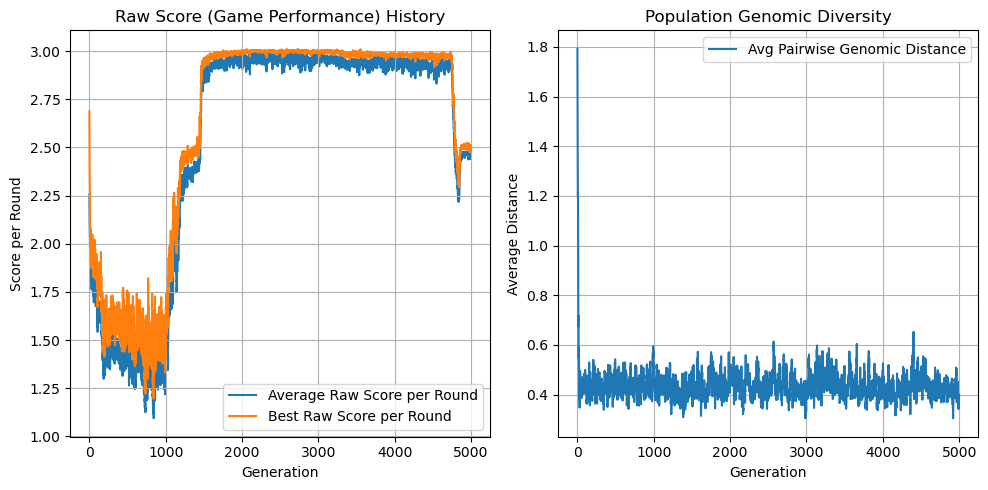

In [17]:
def plot_population(avg_raw_score_history, best_raw_score_history, population_diversity_history, dot_frequency = None):
    # --- Plotting Results ---
    plt.figure(figsize=(10, 5))

    # Plot 1: Fitness History (Raw Score)
    plt.subplot(1, 2, 1)
    plt.plot(avg_raw_score_history, label="Average Raw Score per Round", zorder=1)
    plt.plot(best_raw_score_history, label="Best Raw Score per Round", zorder=2)
    if dot_frequency:
        for i in range(dot_frequency, len(avg_raw_score_history), dot_frequency):
            plt.axvline(x=i, color='gray', linestyle='--', alpha=0.5)
        plt.axvline(x=dot_frequency, color='gray', linestyle='--', alpha=0.5, label="Migration")
    plt.xlabel("Generation")
    plt.ylabel("Score per Round")
    plt.title("Raw Score (Game Performance) History")
    plt.legend()
    plt.grid(True)
    

    # Plot 2: Population Diversity
    plt.subplot(1, 2, 2)
    plt.plot(population_diversity_history, label="Avg Pairwise Genomic Distance")
    if dot_frequency:
        for i in range(dot_frequency, len(avg_raw_score_history), dot_frequency):
            plt.axvline(x=i, color='gray', linestyle='--', alpha=0.5)
        plt.axvline(x=dot_frequency, color='gray', linestyle='--', alpha=0.5, label="Migration")
    plt.xlabel("Generation")
    plt.ylabel("Average Distance")
    plt.title("Population Genomic Diversity")
    plt.legend()
    plt.grid(True)


    plt.tight_layout()
    plt.show()

plot_population(avg_raw_score_history, best_raw_score_history, population_diversity_history)

Analyzing the plots, we observe that the best raw score initially drops sharply, then rises rapidly before reaching a plateau. This pattern can be explained as follows:

- In the early generations, some randomly generated strategies perform well simply because they are competing against other naive, randomly generated strategies that are easy to exploit.
- As evolution progresses, the population as a whole becomes more sophisticated. The initially successful strategies now face stronger opponents and may lose their advantage, leading to a temporary decrease in the best score.
- After several more generations, genuinely effective strategies begin to emerge and dominate the population, causing the best score to rise again and eventually stabilize at a plateau.

Interestingly, after reaching the plateau, right before the final generations, the best score drops again. This is likely due to the population becoming too homogeneous, with most individuals converging on similar strategies. As a result, the population becomes less adaptive to new strategies, leading to a decline in performance.

To further confirm this, we notice that the average raw score closely tracks the best raw score throughout the process. This suggests that the population quickly becomes homogeneous, with most individuals adopting similar strategies. This lack of diversity is further confirmed by the plot of genomic diversity, which shows a sharp decline over time. Such rapid loss of diversity can lead to premature convergence, where the population gets stuck in suboptimal regions of the strategy space and potentially useful strategies are lost.

In [7]:
def analyse_evolved_strategy(population):
    # --- Analysis of Evolved Strategies ---
    last_generation = population[-1]
    last_generation.sort(key=lambda ind: ind.avg_score_per_round, reverse=True) # Sort by raw game performance

    print("Best 2 individuals (by raw score):")
    for i in range(min(2, len(last_generation))):
        ind = last_generation[i]
        print(f"\nIndividual {ind.id}: Raw Score: {ind.avg_score_per_round:.3f}")
        # print(f"  Genome (P(Cooperate) for 16 states): {np.round(ind.genome, 2)}")
        # For easier reading, let's map history states to their P(Cooperate)
        print("  Strategy Highlights (P(Cooperate)):")
        # History state: (My_t-1, My_t-2, Opp_t-1, Opp_t-2)
        # Example states:
        # (C,C,C,C) -> (0,0,0,0) -> index 0
        # (D,D,D,D) -> (1,1,1,1) -> index 15
        # (C,C,D,D) -> (0,0,1,1) -> index 3 (I was cooperating, opponent defected twice)
        # (D,C,C,C) -> (1,0,0,0) -> index 8 (I defected after cooperating, opponent cooperated)
        
        hist_cc_cc_idx = 3 + rpd.get_history_index([rpd.COOPERATE, rpd.COOPERATE], [rpd.COOPERATE, rpd.COOPERATE]) # My C,C; Opp C,C
        hist_cd_cd_idx = 3 + rpd.get_history_index([rpd.COOPERATE, rpd.DEFECT], [rpd.COOPERATE, rpd.DEFECT]) # My C,D; Opp C,D (Tit-for-Tat like response)
        hist_dd_dd_idx = 3 + rpd.get_history_index([rpd.DEFECT, rpd.DEFECT], [rpd.DEFECT, rpd.DEFECT]) # My D,D; Opp D,D
        hist_cc_dd_idx = 3 + rpd.get_history_index([rpd.COOPERATE, rpd.COOPERATE], [rpd.DEFECT, rpd.DEFECT]) # My C,C; Opp D,D (Sucker)
        hist_dd_cc_idx = 3 + rpd.get_history_index([rpd.DEFECT, rpd.DEFECT], [rpd.COOPERATE, rpd.COOPERATE]) # My D,D; Opp C,C (Temptation exploited

        print(f"    P(C in first round): {ind.genome[0]:.2f} (Idx 0)")
        print(f"    P(C | My C,C; Opp C,C): {ind.genome[hist_cc_cc_idx]:.2f} (Idx {hist_cc_cc_idx})")
        print(f"    P(C | My C,C; Opp D,D): {ind.genome[hist_cc_dd_idx]:.2f} (Idx {hist_cc_dd_idx})")
        print(f"    P(C | My D,D; Opp C,C): {ind.genome[hist_dd_cc_idx]:.2f} (Idx {hist_dd_cc_idx})")
        print(f"    P(C | My D,D; Opp D,D): {ind.genome[hist_dd_dd_idx]:.2f} (Idx {hist_dd_dd_idx})")

print("\n--- Analysis of Final Population ---")
analyse_evolved_strategy(population)


--- Analysis of Final Population ---
Best 2 individuals (by raw score):

Individual 249976: Raw Score: 1.482
  Strategy Highlights (P(Cooperate)):
    P(C in first round): 0.41 (Idx 0)
    P(C | My C,C; Opp C,C): 0.32 (Idx 3)
    P(C | My C,C; Opp D,D): 0.25 (Idx 6)
    P(C | My D,D; Opp C,C): 0.16 (Idx 15)
    P(C | My D,D; Opp D,D): 0.00 (Idx 18)

Individual 249969: Raw Score: 1.476
  Strategy Highlights (P(Cooperate)):
    P(C in first round): 0.39 (Idx 0)
    P(C | My C,C; Opp C,C): 0.37 (Idx 3)
    P(C | My C,C; Opp D,D): 0.22 (Idx 6)
    P(C | My D,D; Opp C,C): 0.26 (Idx 15)
    P(C | My D,D; Opp D,D): 0.12 (Idx 18)


## Preserving Diversity with the Island Model

To address the fast loss of diversity, we implement an implicit diversity-preservation method: **the island model**. In this model, the population is divided into several subpopulations (islands) that evolve mostly independently, with occasional migration of individuals between islands. This helps preserve diversity and allows for the parallel exploration of different regions of the strategy space.

Specifically, we choose to migrate the best agents without copying them: this means that for each island, the best agents will be replaced by the best agents from the neighboring island.

A note on the implementation: the island model is implemented in order to exploit multi-core architectures (using the `multiprocessing` library in Python). If the `processes` parameter is set to -1, the function will automatically use all available cores, up to the number of islands to evolve. The choice of 8 islands in this case is dictated by the number of cores in my laptop.

In [8]:
MIGRATION_FREQUENCY = 250
N_ISLANDS = 8
N_MIGRANTS = 5

PROCESSES = 8

In [9]:
populations = rpd.run_island_model(POPULATION_SIZE, N_GENERATIONS, N_OPPONENTS_TO_PLAY, ROUNDS_PER_GAME, ELITE_SIZE, MUTATION_RATE, MUTATION_STRENGTH, CROSSOVER_ALPHA, MIGRATION_FREQUENCY, N_ISLANDS, N_MIGRANTS, VERBOSITY, PROCESSES)

Migration 1...
Migration 2...
Migration 3...
Migration 4...
Migration 5...
Migration 6...
Migration 7...
Migration 8...
Migration 9...
Migration 10...
Migration 11...
Migration 12...
Migration 13...
Migration 14...
Migration 15...
Migration 16...
Migration 17...
Migration 18...
Migration 19...
Migration 20...


In [10]:
last_generation_list = [pop[-1] for pop in populations]
last_generation = []
for i in range(len(last_generation_list)):
    last_generation += last_generation_list[i]
len(last_generation)

total_diversity = rpd.calculate_population_diversity(last_generation)

diversity_list = [rpd.calculate_population_diversity(pop) for pop in last_generation_list]
average_diversity = np.mean(diversity_list)
print(f"\n--- Analysis of Population Diversity ---")
print(f"Average Population Diversity: {average_diversity:.2f}")
print(f"Total Population Diversity: {total_diversity:.2f}")


--- Analysis of Population Diversity ---
Average Population Diversity: 0.40
Total Population Diversity: 1.61


We can see here that while the genomic diversity of each individual population is low, the total diversity is high, meaning that the islands do evolve separately despite the migration of the best agents. This is a good sign, as it means that the islands are exploring different regions of the strategy space, and that the migration of the best agents is not leading to premature convergence.

In [11]:
avg_raw_score_histories = [[] for _ in range(N_ISLANDS)]

best_raw_score_histories = [[] for _ in range(N_ISLANDS)]

population_diversity_histories = [[] for _ in range(N_ISLANDS)]

for i, population_list in enumerate(populations):
    for generation in population_list:
        avg_raw_score = np.mean([ind.avg_score_per_round for ind in generation])
        best_raw_score = max([ind.avg_score_per_round for ind in generation])
        population_diversity = rpd.calculate_population_diversity(generation)
        avg_raw_score_histories[i].append(avg_raw_score)
        best_raw_score_histories[i].append(best_raw_score)
        population_diversity_histories[i].append(population_diversity)

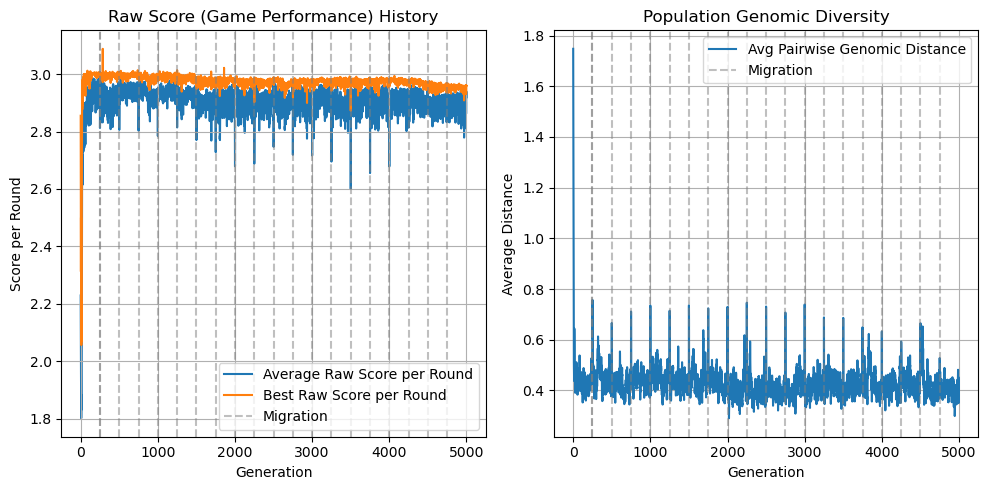

--- Analysis of Final Population on Island 0 ---
Best 2 individuals (by raw score):

Individual 249014: Raw Score: 2.959
  Strategy Highlights (P(Cooperate)):
    P(C in first round): 0.10 (Idx 0)
    P(C | My C,C; Opp C,C): 1.00 (Idx 3)
    P(C | My C,C; Opp D,D): 0.08 (Idx 6)
    P(C | My D,D; Opp C,C): 0.07 (Idx 15)
    P(C | My D,D; Opp D,D): 0.97 (Idx 18)

Individual 249047: Raw Score: 2.958
  Strategy Highlights (P(Cooperate)):
    P(C in first round): 0.16 (Idx 0)
    P(C | My C,C; Opp C,C): 1.00 (Idx 3)
    P(C | My C,C; Opp D,D): 0.18 (Idx 6)
    P(C | My D,D; Opp C,C): 0.00 (Idx 15)
    P(C | My D,D; Opp D,D): 0.94 (Idx 18)


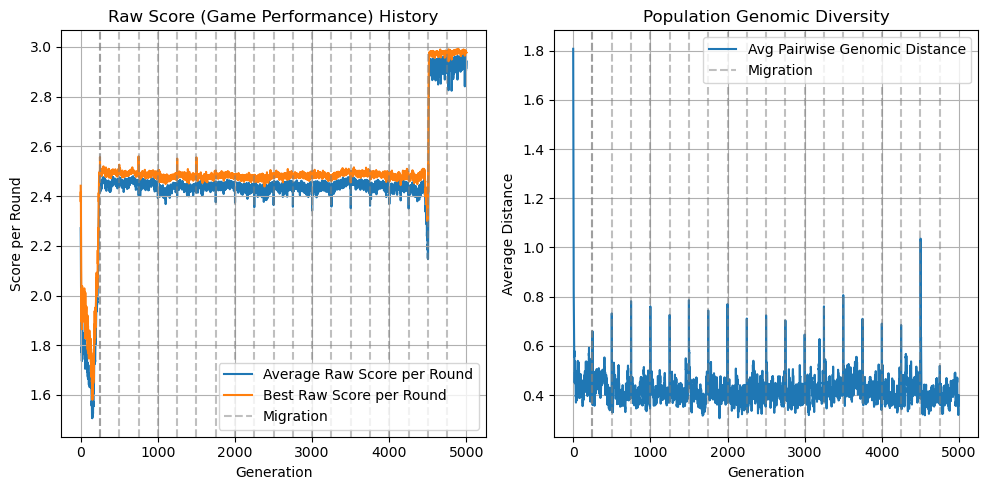

--- Analysis of Final Population on Island 1 ---
Best 2 individuals (by raw score):

Individual 249030: Raw Score: 2.977
  Strategy Highlights (P(Cooperate)):
    P(C in first round): 0.15 (Idx 0)
    P(C | My C,C; Opp C,C): 1.00 (Idx 3)
    P(C | My C,C; Opp D,D): 0.10 (Idx 6)
    P(C | My D,D; Opp C,C): 0.00 (Idx 15)
    P(C | My D,D; Opp D,D): 1.00 (Idx 18)

Individual 249020: Raw Score: 2.975
  Strategy Highlights (P(Cooperate)):
    P(C in first round): 0.03 (Idx 0)
    P(C | My C,C; Opp C,C): 1.00 (Idx 3)
    P(C | My C,C; Opp D,D): 0.27 (Idx 6)
    P(C | My D,D; Opp C,C): 0.15 (Idx 15)
    P(C | My D,D; Opp D,D): 0.89 (Idx 18)


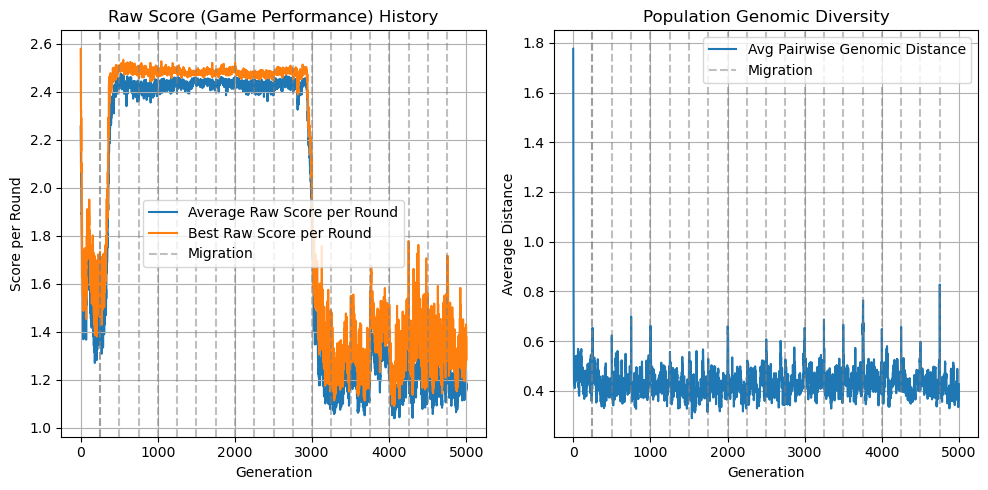

--- Analysis of Final Population on Island 2 ---
Best 2 individuals (by raw score):

Individual 249041: Raw Score: 1.376
  Strategy Highlights (P(Cooperate)):
    P(C in first round): 0.34 (Idx 0)
    P(C | My C,C; Opp C,C): 0.41 (Idx 3)
    P(C | My C,C; Opp D,D): 0.06 (Idx 6)
    P(C | My D,D; Opp C,C): 0.16 (Idx 15)
    P(C | My D,D; Opp D,D): 0.03 (Idx 18)

Individual 249042: Raw Score: 1.334
  Strategy Highlights (P(Cooperate)):
    P(C in first round): 0.34 (Idx 0)
    P(C | My C,C; Opp C,C): 0.40 (Idx 3)
    P(C | My C,C; Opp D,D): 0.00 (Idx 6)
    P(C | My D,D; Opp C,C): 0.30 (Idx 15)
    P(C | My D,D; Opp D,D): 0.01 (Idx 18)


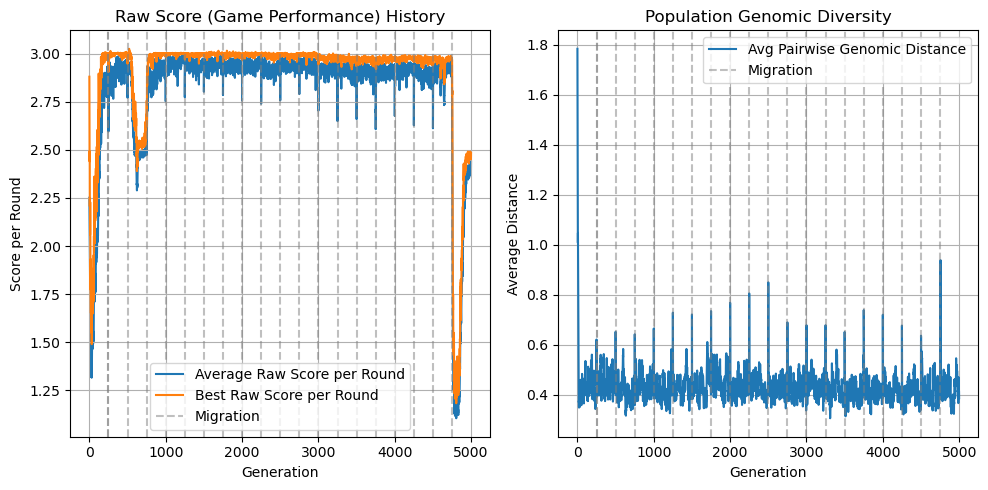

--- Analysis of Final Population on Island 3 ---
Best 2 individuals (by raw score):

Individual 249028: Raw Score: 2.484
  Strategy Highlights (P(Cooperate)):
    P(C in first round): 0.56 (Idx 0)
    P(C | My C,C; Opp C,C): 0.20 (Idx 3)
    P(C | My C,C; Opp D,D): 0.06 (Idx 6)
    P(C | My D,D; Opp C,C): 0.29 (Idx 15)
    P(C | My D,D; Opp D,D): 0.28 (Idx 18)

Individual 249017: Raw Score: 2.483
  Strategy Highlights (P(Cooperate)):
    P(C in first round): 0.50 (Idx 0)
    P(C | My C,C; Opp C,C): 0.17 (Idx 3)
    P(C | My C,C; Opp D,D): 0.16 (Idx 6)
    P(C | My D,D; Opp C,C): 0.25 (Idx 15)
    P(C | My D,D; Opp D,D): 0.19 (Idx 18)


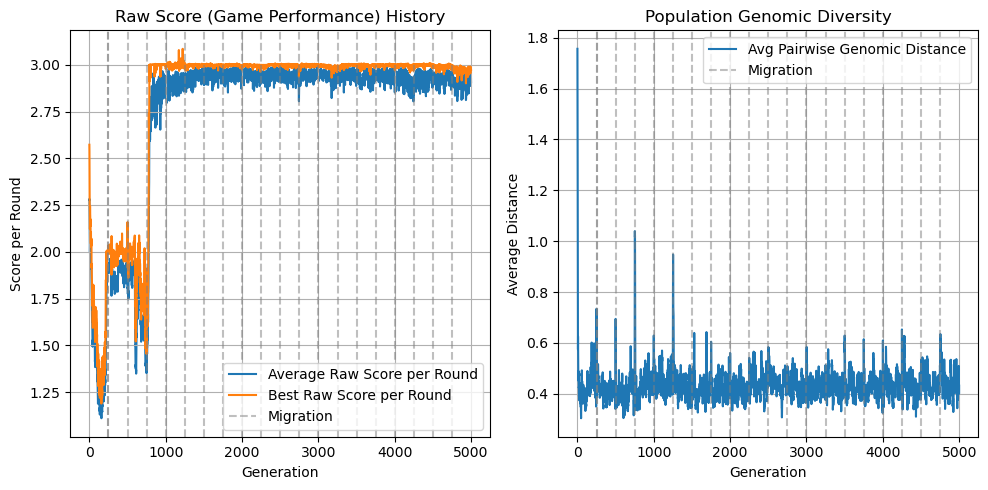

--- Analysis of Final Population on Island 4 ---
Best 2 individuals (by raw score):

Individual 249042: Raw Score: 2.974
  Strategy Highlights (P(Cooperate)):
    P(C in first round): 0.30 (Idx 0)
    P(C | My C,C; Opp C,C): 0.99 (Idx 3)
    P(C | My C,C; Opp D,D): 0.19 (Idx 6)
    P(C | My D,D; Opp C,C): 0.14 (Idx 15)
    P(C | My D,D; Opp D,D): 0.54 (Idx 18)

Individual 249002: Raw Score: 2.963
  Strategy Highlights (P(Cooperate)):
    P(C in first round): 0.25 (Idx 0)
    P(C | My C,C; Opp C,C): 1.00 (Idx 3)
    P(C | My C,C; Opp D,D): 0.33 (Idx 6)
    P(C | My D,D; Opp C,C): 0.04 (Idx 15)
    P(C | My D,D; Opp D,D): 0.46 (Idx 18)


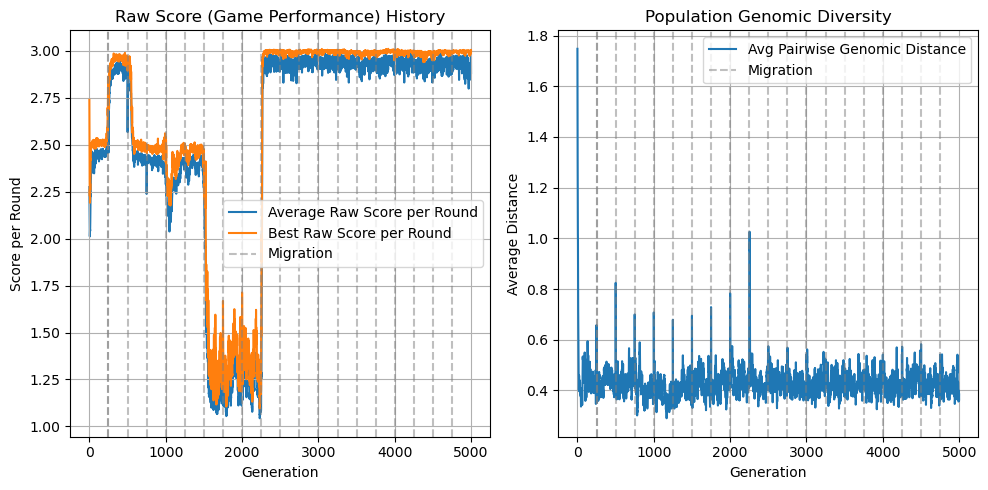

--- Analysis of Final Population on Island 5 ---
Best 2 individuals (by raw score):

Individual 249032: Raw Score: 2.998
  Strategy Highlights (P(Cooperate)):
    P(C in first round): 0.96 (Idx 0)
    P(C | My C,C; Opp C,C): 1.00 (Idx 3)
    P(C | My C,C; Opp D,D): 0.39 (Idx 6)
    P(C | My D,D; Opp C,C): 0.21 (Idx 15)
    P(C | My D,D; Opp D,D): 0.69 (Idx 18)

Individual 249015: Raw Score: 2.991
  Strategy Highlights (P(Cooperate)):
    P(C in first round): 0.98 (Idx 0)
    P(C | My C,C; Opp C,C): 1.00 (Idx 3)
    P(C | My C,C; Opp D,D): 0.41 (Idx 6)
    P(C | My D,D; Opp C,C): 0.35 (Idx 15)
    P(C | My D,D; Opp D,D): 0.63 (Idx 18)


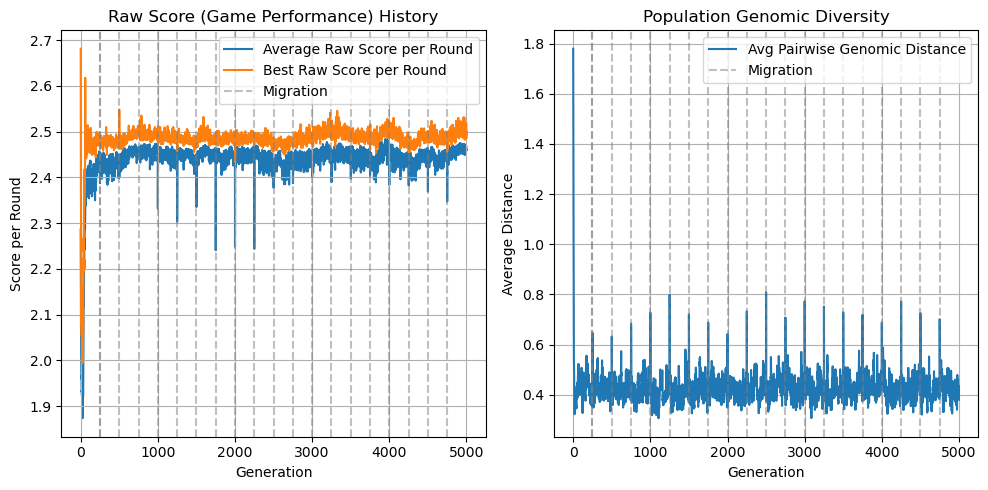

--- Analysis of Final Population on Island 6 ---
Best 2 individuals (by raw score):

Individual 249034: Raw Score: 2.500
  Strategy Highlights (P(Cooperate)):
    P(C in first round): 0.27 (Idx 0)
    P(C | My C,C; Opp C,C): 0.46 (Idx 3)
    P(C | My C,C; Opp D,D): 0.35 (Idx 6)
    P(C | My D,D; Opp C,C): 0.28 (Idx 15)
    P(C | My D,D; Opp D,D): 0.45 (Idx 18)

Individual 249038: Raw Score: 2.496
  Strategy Highlights (P(Cooperate)):
    P(C in first round): 0.36 (Idx 0)
    P(C | My C,C; Opp C,C): 0.55 (Idx 3)
    P(C | My C,C; Opp D,D): 0.33 (Idx 6)
    P(C | My D,D; Opp C,C): 0.51 (Idx 15)
    P(C | My D,D; Opp D,D): 0.40 (Idx 18)


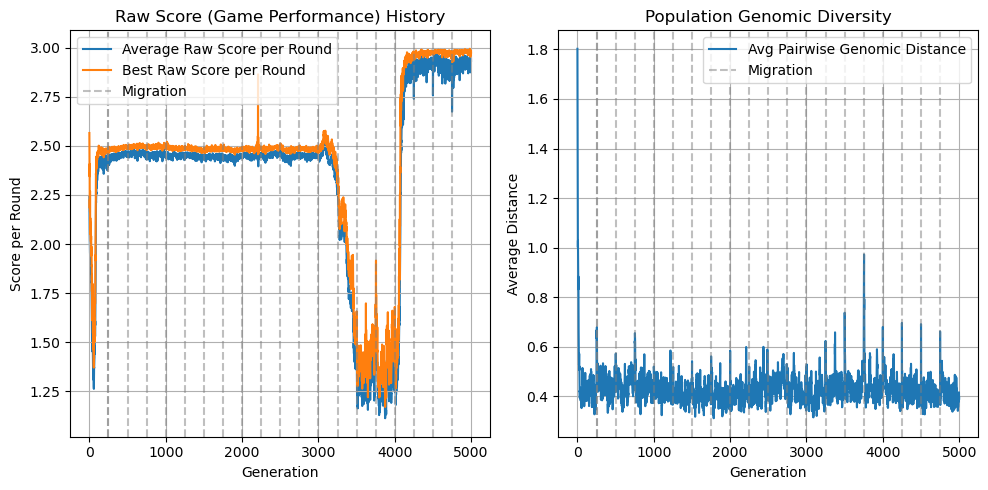

--- Analysis of Final Population on Island 7 ---
Best 2 individuals (by raw score):

Individual 249031: Raw Score: 2.975
  Strategy Highlights (P(Cooperate)):
    P(C in first round): 0.03 (Idx 0)
    P(C | My C,C; Opp C,C): 1.00 (Idx 3)
    P(C | My C,C; Opp D,D): 0.19 (Idx 6)
    P(C | My D,D; Opp C,C): 0.14 (Idx 15)
    P(C | My D,D; Opp D,D): 0.91 (Idx 18)

Individual 249016: Raw Score: 2.973
  Strategy Highlights (P(Cooperate)):
    P(C in first round): 0.02 (Idx 0)
    P(C | My C,C; Opp C,C): 1.00 (Idx 3)
    P(C | My C,C; Opp D,D): 0.39 (Idx 6)
    P(C | My D,D; Opp C,C): 0.27 (Idx 15)
    P(C | My D,D; Opp D,D): 0.93 (Idx 18)


In [12]:
for i in range(N_ISLANDS):
    plot_population(avg_raw_score_histories[i], best_raw_score_histories[i], population_diversity_histories[i], dot_frequency=MIGRATION_FREQUENCY)
    print(f"--- Analysis of Final Population on Island {i} ---")
    analyse_evolved_strategy(populations[i])

From the plots and analysis of each island, we observe that the diversity within each island remains low for most of the evolutionary process. As a result, the average strategy on each island tends to closely mirror the behavior of the best-performing individual. This homogeneity is a sign of rapid convergence within each subpopulation.

However, at migration events, we notice two important phenomena:
- The raw score of the best agents often exhibits sudden jumps, indicating that the influx of new individuals from other islands enables the population to escape local optima and discover better strategies.
- Population diversity spikes immediately after migration, reflecting the introduction of novel genetic material. This provides the population with new directions for exploration, and the subsequent evolutionary process determines whether these new strategies are adopted or discarded.

These observations confirm that the island model is effective at periodically injecting diversity and helping the evolutionary process escape local optima. This is precisely the intended effect of this approach.

Examining the evolved strategies after 5000 generations, we find that the best individuals from different islands can still differ significantly from one another. This highlights a fundamental property of the Repeated Prisoner's Dilemma: 

- The effectiveness of a strategy is highly dependent on the strategies present in the rest of the population. There is no single "best" strategy in isolation; rather, success is context-dependent and shaped by the ongoing coevolutionary dynamics.
- The memory length of the strategies also plays a crucial role. In our implementation, each agent can condition its actions on the previous two rounds of play. While this allows for a rich set of behaviors, it is still a limited memory. More sophisticated strategies might require longer memory or even different representations to capture more complex patterns of interaction. However, increasing the memory length would also increase the dimensionality of the search space, making it harder to explore effectively. This is a trade-off that needs to be carefully considered in future work. Another drawback of a higher dimensionality is the loss of interpretability of the strategies.

In summary, the combination of coevolution and the island model enables the discovery of a diverse set of effective strategies, each adapted to the local context of its island. This diversity is essential for robust performance in the Repeated Prisoner's Dilemma, where adaptability and the ability to respond to a wide range of opponents are key to long-term success.

Importantly, the methods and observations here are not limited to the Prisoner's Dilemma. Similar coevolutionary and diversity-preserving techniques can be applied to other social dilemmas and multi-agent environments.